In [2]:
# some regular python libraries
import networkx as nx
import matplotlib.pyplot as plt

# OpenQAOA imports
from openqaoa import QAOA
from openqaoa.problems import MaximumCut
from openqaoa.backends import create_device
from openqaoa.utilities import ground_state_hamiltonian,plot_graph
from openqaoa.utilities import plot_graph

# some useful qiskit imports
from qiskit import transpile
from qiskit_aer.noise import (NoiseModel, depolarizing_error)

/global/homes/g/gzquse/.local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


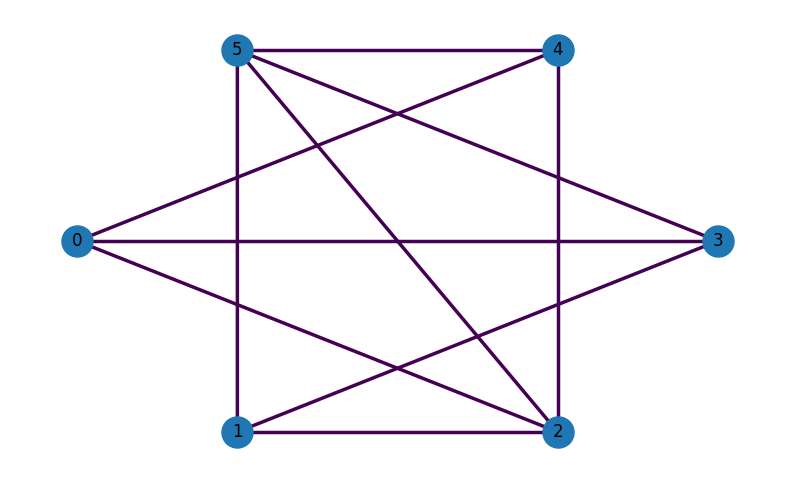

In [3]:
nodes = 6
edge_probability = 0.6
g = nx.generators.fast_gnp_random_graph(n=nodes, p=edge_probability, seed=42)

# import graph plotter from openqaoa
plot_graph(g)

# create the maximum cut instance and get its QUBO
maxcut = MaximumCut(g)
maxcut_qubo = maxcut.qubo

In [15]:
maxcut_qubo

In [4]:
hamiltonian =  maxcut_qubo.hamiltonian

energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution/s: {configuration}")

Ground State energy: -6.0, Solution/s: ['001110', '110001']


In [5]:
# gates to add noise
one_qubit_gates = ['h','rx']
two_qubits_gates = ['cx']

def add_depolarizing_error(noise_model,probability1, probability2):
    noise_model = add_one_qubit_depolarizing_error(noise_model,probability1)
    noise_model = add_two_qubits_depolarizing_error(noise_model,probability2)
    return noise_model

def add_one_qubit_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 1)
    noise_model.add_all_qubit_quantum_error(error,one_qubit_gates)
    return noise_model

def add_two_qubits_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 2)
    noise_model.add_all_qubit_quantum_error(error, two_qubits_gates)
    return noise_model

#create the noise model
noise_model = add_depolarizing_error(NoiseModel(),0.0001989 ,0.007905)
noise_model

<NoiseModel on ['rx', 'cx', 'h']>

In [6]:
# create, configure and run the QAOA
q1 = QAOA()

qiskit_device = create_device(location='local', name='qiskit.shot_simulator')

q1.set_device(qiskit_device)

q1.set_circuit_properties(p=4, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

q1.set_backend_properties(n_shots=5000,seed_simulator=1)

q1.set_classical_optimizer(method='Powell', maxiter=200, tol=0.01,maxfev=5000, optimization_progress=True, cost_progress=True, parameter_log=True)

q1.compile(maxcut_qubo)

q1.optimize()

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Cost history'}, xlabel='Number of function evaluations', ylabel='Cost'>)

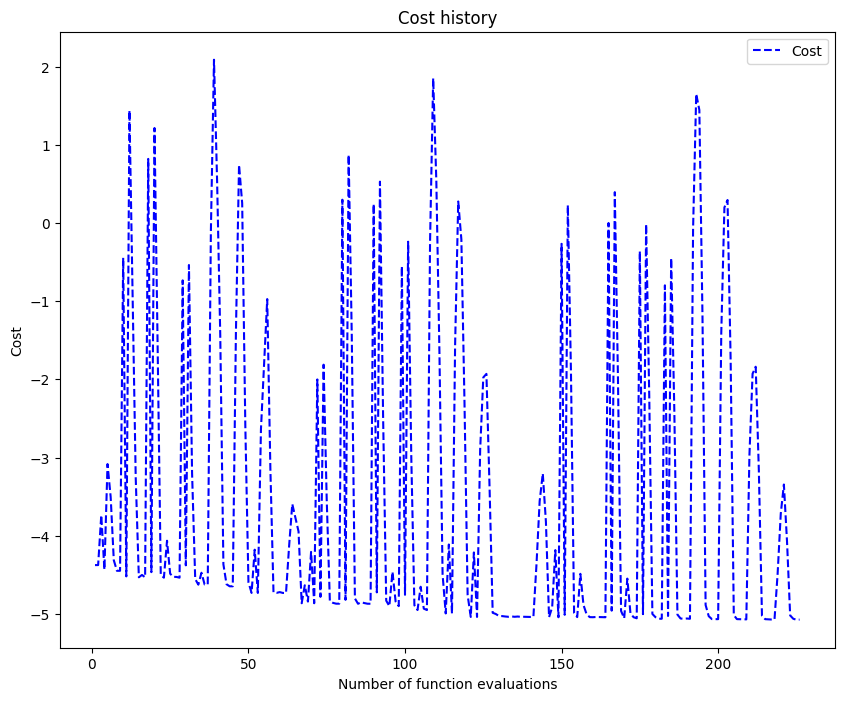

In [7]:
# access the results
opt_results1 = q1.result
opt_results1.plot_cost()

In [8]:
# create, configure and run the QAOA
q2 = QAOA()

qiskit_device = create_device(location='local', name='qiskit.shot_simulator')

q2.set_device(qiskit_device)

q2.set_circuit_properties(p=4, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

# here it is set the noise model
q2.set_backend_properties(n_shots=5000, noise_model=noise_model,seed_simulator=1)

q2.set_classical_optimizer(method='Powell', maxiter=200, tol=0.01,maxfev=5000, optimization_progress=True, cost_progress=True, parameter_log=True)

q2.compile(maxcut_qubo)

# it is necessary to transpile the parametric circuit with the same basis gates that has the noise model
q2.backend.parametric_circuit = transpile(q2.backend.parametric_circuit,basis_gates=["h","rx","cx"])

q2.optimize()

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Cost history'}, xlabel='Number of function evaluations', ylabel='Cost'>)

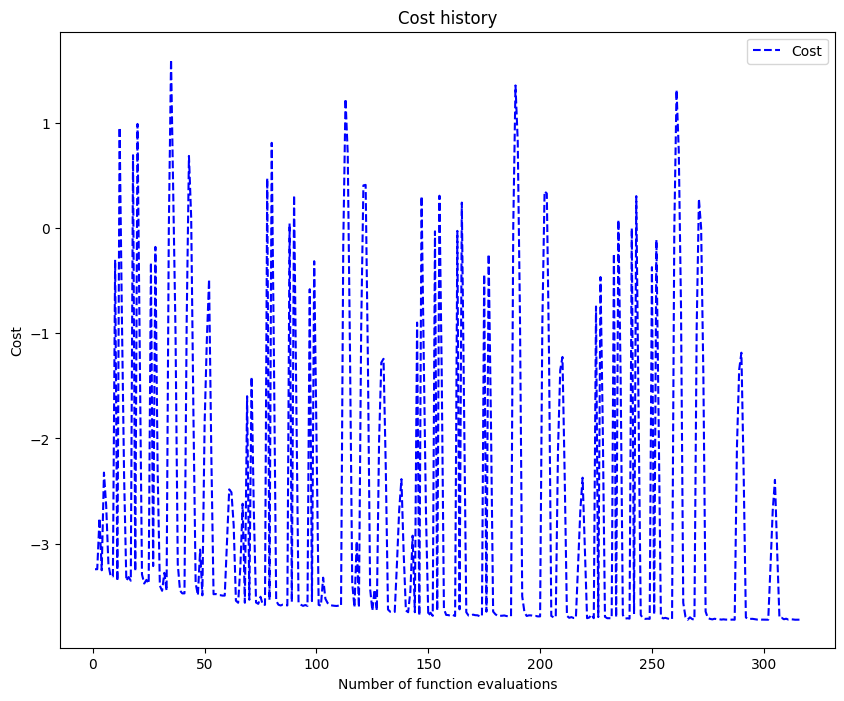

In [9]:
# access the results
opt_results2 = q2.result
opt_results2.plot_cost()

In [10]:
# create, configure and run the QAOA
q3 = QAOA()

qiskit_device = create_device(location='local', name='qiskit.shot_simulator')

q3.set_device(qiskit_device)

q3.set_circuit_properties(p=4, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

# here is set the noise model
q3.set_backend_properties(n_shots=5000,seed_simulator=1,noise_model=noise_model)

q3.set_classical_optimizer(method='Powell', maxiter=100, tol=0.01,maxfev=5000, optimization_progress=True, cost_progress=True, parameter_log=True)

# here is set the ZNE
q3.set_error_mitigation_properties(error_mitigation_technique='mitiq_zne',factory = 'Richardson', scale_factors = [1,2,3])

q3.compile(maxcut_qubo)

q3.optimize()

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Cost history'}, xlabel='Number of function evaluations', ylabel='Cost'>)

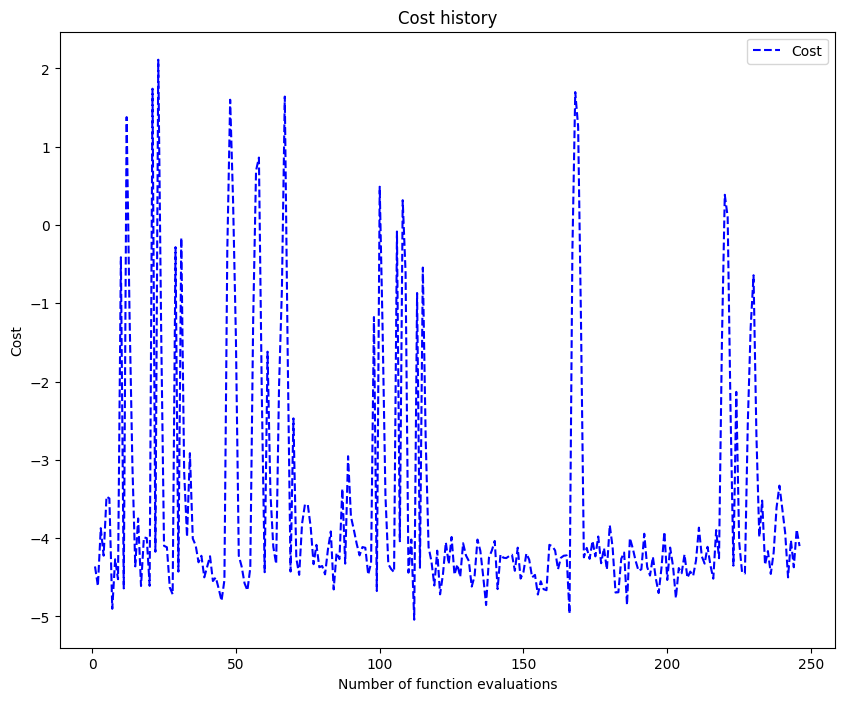

In [12]:
opt_results3 = q3.result
opt_results3.plot_cost()

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Cost history'}, xlabel='Number of function evaluations', ylabel='Cost'>)

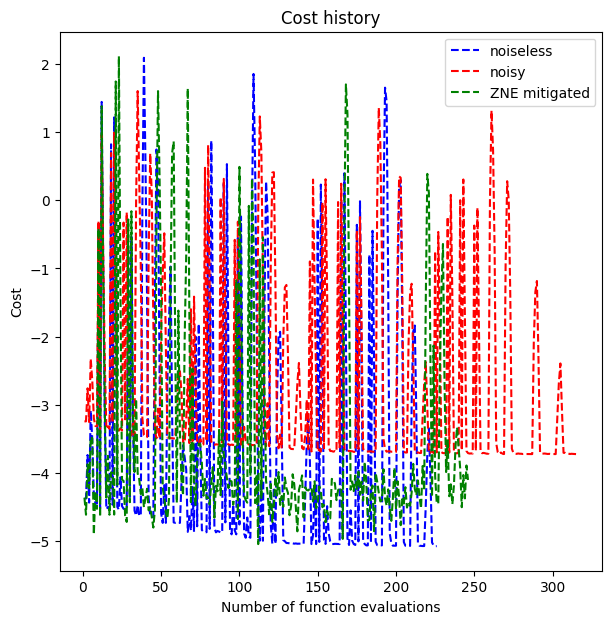

In [13]:
fig, ax = plt.subplots(figsize=(7,7))
opt_results1.plot_cost(figsize=(7,7),color='blue',label='noiseless',ax=ax)
opt_results2.plot_cost(figsize=(7,7),color='red',label='noisy',ax=ax)
opt_results3.plot_cost(figsize=(7,7),color='green',label='ZNE mitigated',ax=ax)

AMOUNT OF EXTRAPOLATIONS:  246
-----
EXTRAPOLATED COST NUMBER  1


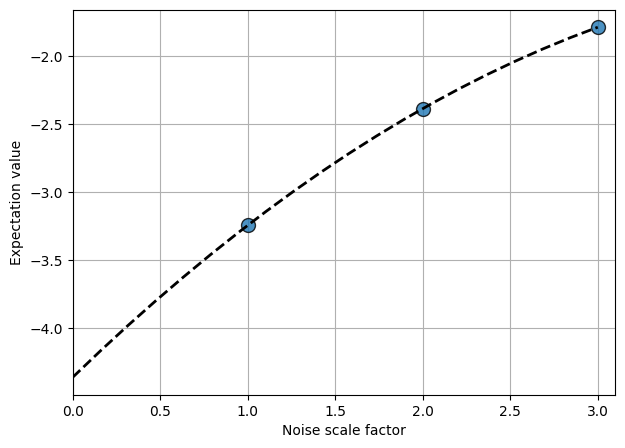

-----
...


In [14]:
print('AMOUNT OF EXTRAPOLATIONS: ',len(q3.backend.result_factory_objs))
extrapolated_costs = q3.backend.result_factory_objs[0:1]
for i,extrapolated_cost in enumerate(extrapolated_costs):
    print('-----')
    print('EXTRAPOLATED COST NUMBER ',i+1)
    fit=extrapolated_cost.plot_fit()
    plt.close()
    display(fit)
print('-----')
print('...')